In [1]:
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import os

# Our local modules
import src.calibrate as clb
import src.util as util

# Check that we're in the correct folder

For the code in this notebook to work correctly, the Jupyter server must be started from the `endoscope-calibration` folder. Then you put all of your data in the `./endoscope-calibration/data/`. 

In [2]:
# Check that we're in the right directory
base_dir_name = 'endoscope-calibration'
cwd = os.getcwd()
if not cwd.endswith(base_dir_name):
    print('[WARNING] Your base directory is not \'{}\' - are you running '
          'Jupyter in the correct server?'.format(base_dir_name))
    
data_dir = path.join(cwd, 'data')

# Determine preprocessing parameters

We're gonna visualise several several frames from the video an see how well we can detect the chessboard grid.

In [3]:
# Set the amount of inner corners in the chessboard pattern
vertical_corner_count = 7
horizontal_corner_count = 9
cb_size = (vertical_corner_count, horizontal_corner_count)

# Set brightness and contrast adjustment
brightness_adj = 120
contrast_adj = -20

# Choose the video (from the `data` folder) and how many frames
video_name = 'handheld-endoscope-calibration.avi'
frames_to_preview = 5

## Preprocessing function:

In [4]:
def preprocess(in_frame):
    gray = cv.cvtColor(in_frame, cv.COLOR_BGR2GRAY)
#     kernel_size = 19
#     kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)
#     pp_gray = cv.bilateralFilter(gray, 12, kernel_size, kernel_size)    
    pp_gray = util.apply_brightness_contrast(gray, brightness_adj, contrast_adj)
#     pp_gray = cv.adaptiveThreshold(pp_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 155, 1)
    pp_gray = cv.medianBlur(pp_gray, 7)
    return pp_gray

Chessboard pattern detected on 3 out of 5 frames.


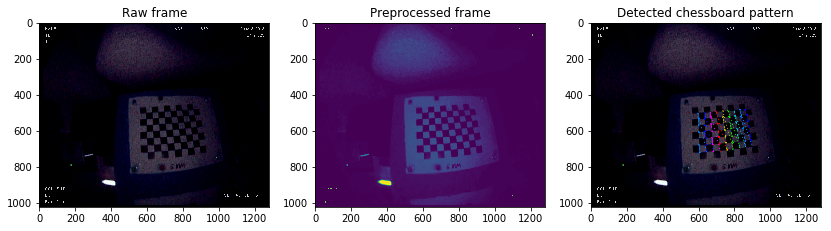

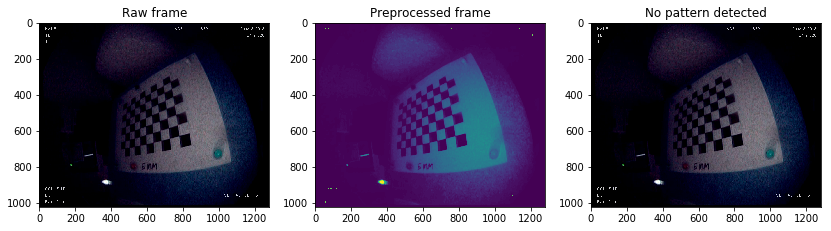

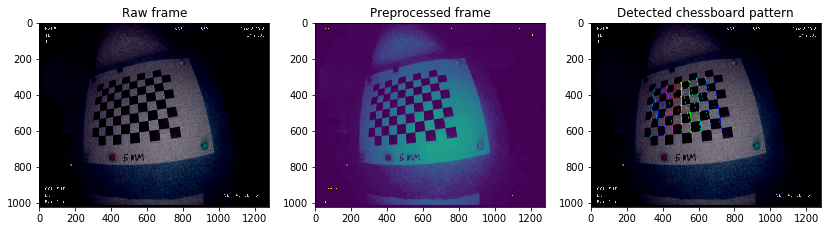

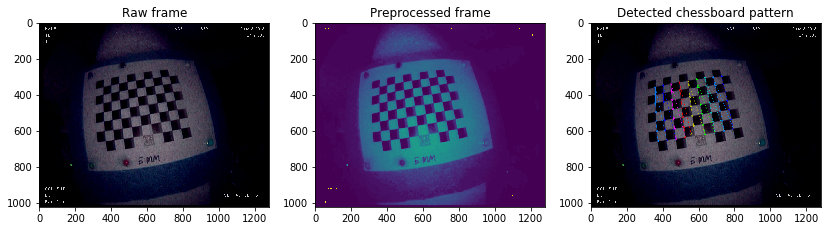

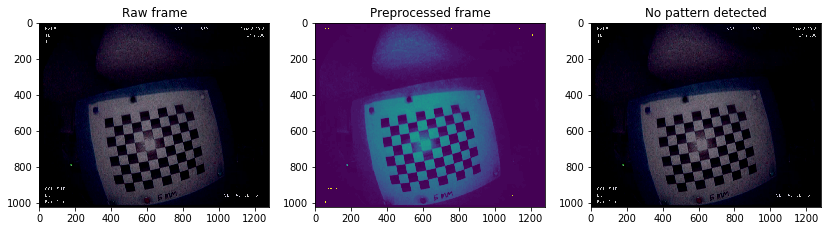

In [5]:
cap = cv.VideoCapture(path.join(data_dir, video_name))
preview_frames = util.pick_equidistant_frames(cap, frames_to_preview)
term_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

detection_count = 0
for frame in preview_frames:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))
    
    pp_frame = preprocess(frame)
    ret, corners = cv.findChessboardCorners(pp_frame, cb_size, None)
    
    ax[0].set_title('Raw frame')
    ax[0].imshow(frame)
    ax[1].set_title('Preprocessed frame')
    ax[1].imshow(pp_frame)
    
    if ret:
        corners2 = cv.cornerSubPix(pp_frame, corners, (11, 11), (-1, -1), term_criteria)
        cb_img = cv.drawChessboardCorners(frame, cb_size, corners2, ret)
        ax[2].set_title('Detected chessboard pattern')
        ax[2].imshow(cb_img)
        detection_count += 1
    else:
        ax[2].set_title('No pattern detected')
        ax[2].imshow(frame)

print('Chessboard pattern detected on {} out of {} frames.'.format(detection_count, len(preview_frames)))

# Perform calibration on the video

In [6]:
# Minimum amount of frames with that detected pattern
frames_with_pattern = 100

world_points, img_points = clb.get_detected_chessboard_points(cap, cb_size, frames_with_pattern,
                                                              term_criteria=term_criteria,
                                                              preprocess_func=preprocess
                                                             )

Processing frame 203 out of 420   (found pattern on 100 frames, need 0 more)
Found 100 points, terminating the loop.


In [7]:
cam_matrix, dist_coeffs, rvecs, tvecs = clb.calculate_camera_intrinsics(world_points,
                                                                        img_points,
                                                                        preview_frames[0]
                                                                       )

In [8]:
# Store the results in a JSON file, rounding o 3 d.p.
intrinsics_file = path.join(data_dir, 'intrinsics.json')
util.save_intrinsics(intrinsics_file, cam_matrix, dist_coeffs)

# Print out the results
print('Camera matrix:')
print(cam_matrix)
print('\nDistortion coefficients:')
print(dist_coeffs)

Camera matrix:
[[588.41067947   0.         647.44152242]
 [  0.         617.09278774 495.99417495]
 [  0.           0.           1.        ]]

Distortion coefficients:
[[-0.28678236  0.01675059  0.00041317 -0.00218783  0.11980717]]


# Undistort the preview frames

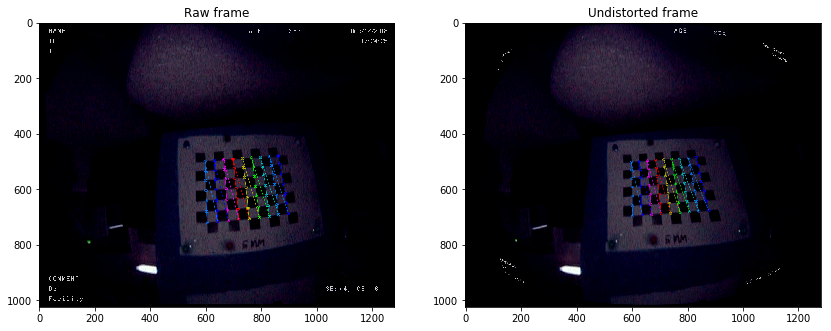

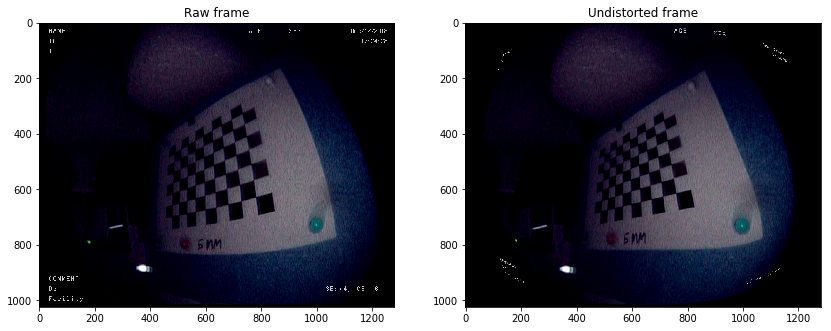

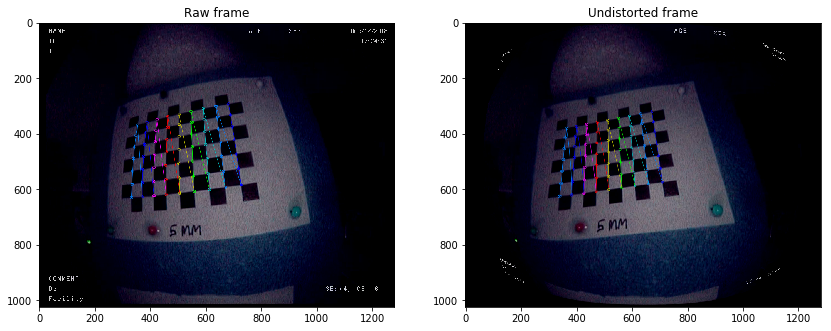

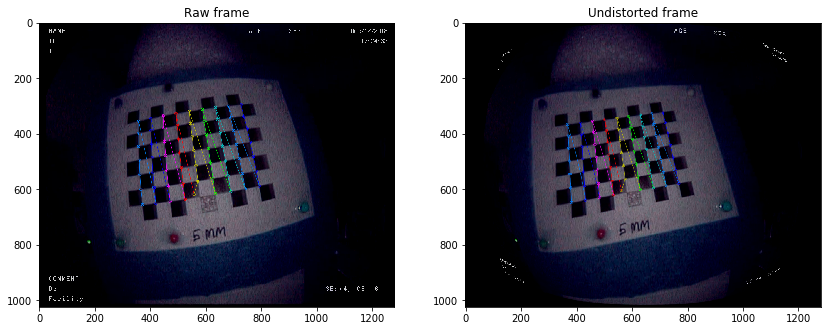

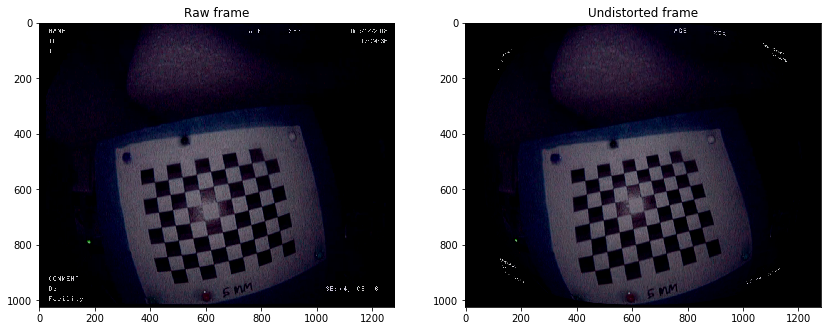

In [9]:
h, w = preview_frames[0].shape[:2]
new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                   (w, h), 1, (w, h))

for frame in preview_frames:
    fixed_frame = cv.undistort(frame, cam_matrix, dist_coeffs, 
                               None, new_cam_matrix)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    ax[0].set_title('Raw frame')
    ax[0].imshow(frame)
    ax[1].set_title('Undistorted frame')
    ax[1].imshow(fixed_frame)